In [1]:
import numpy as np
import sys
from scipy.stats import gamma as gam
from scipy.stats import norm as NORM
import matplotlib.pyplot as plt
from matplotlib import gridspec

from math import gamma
from numpy.core.numeric import zeros_like
from numpy import sqrt, cos, sin, meshgrid, mod, exp,size, zeros, pi,arange, array,arctan2,ceil,zeros_like,shape, reshape, cumsum, log
from numpy.random import multivariate_normal, rand, normal,poisson
from scipy.spatial.distance import cdist

In [2]:
PSFtype='AS'; D=20; Dt=20; NFrame=100; I=4000; Bg=[10,25]; Number=2; Scale=2
struct = np.load('/home/reza/software/BNP_SMTM/code_data/code_data/PSFstruct_3RND8.npy', allow_pickle=True)
Data = np.load('/home/reza/software/BNP_SMTM/code_data/code_data/Data_3RND8.npy')
PSFstruct = struct[()]

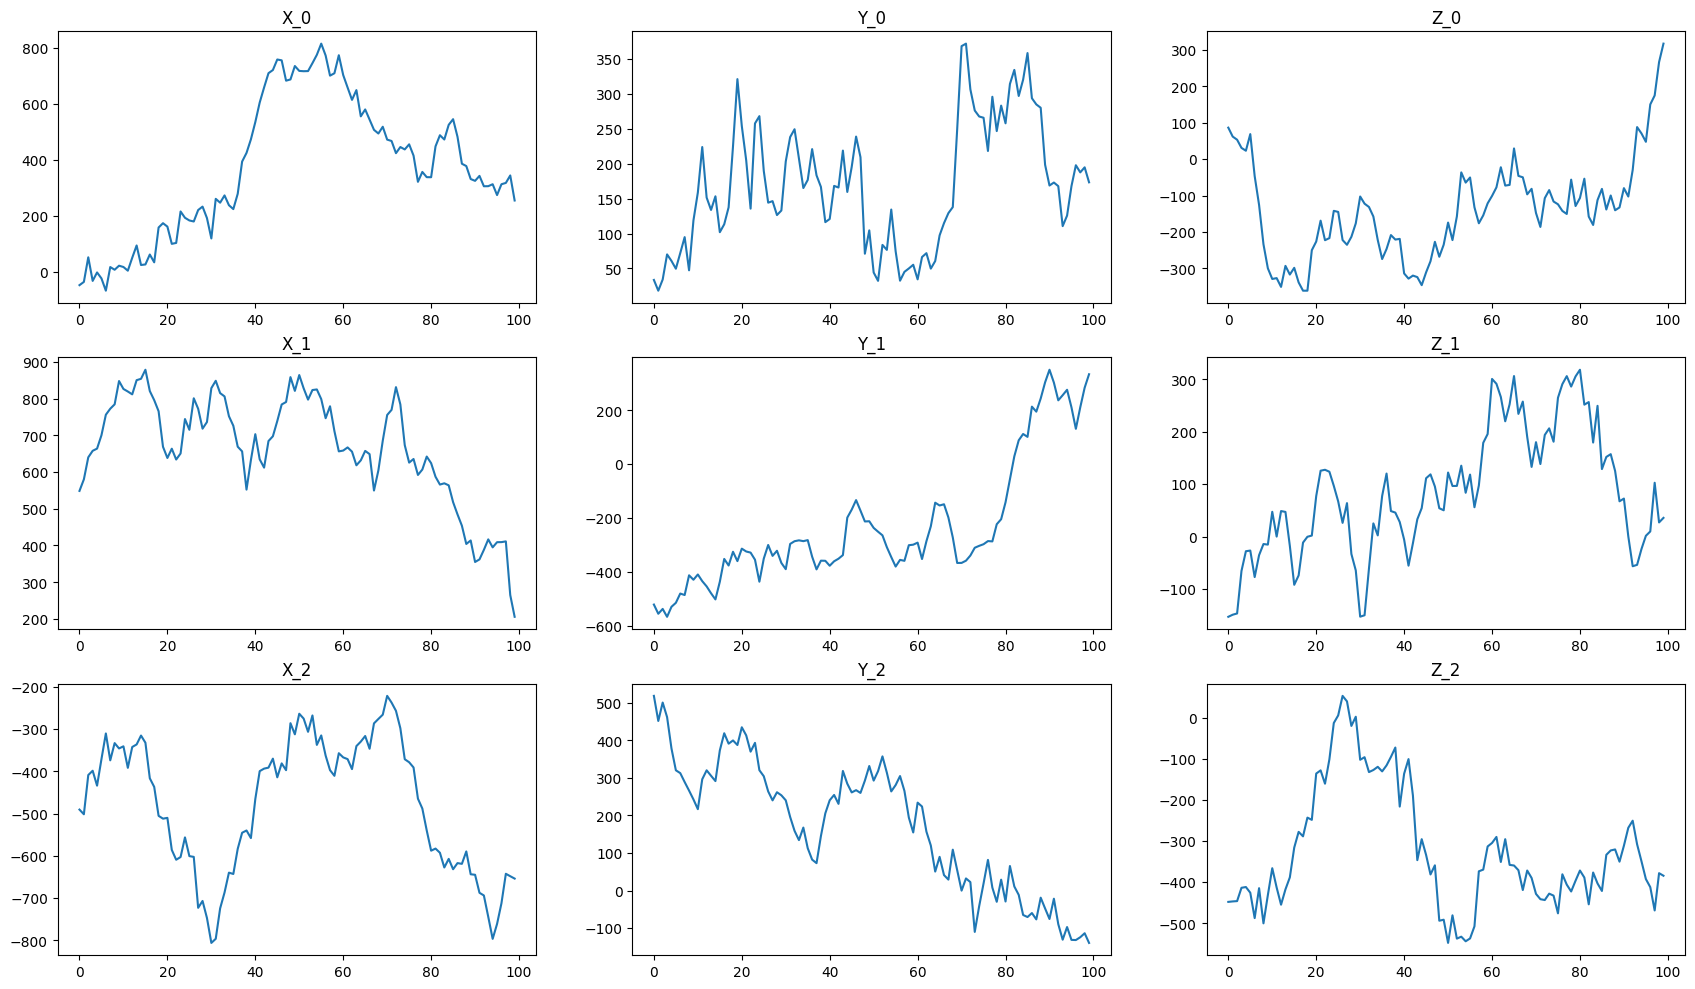

In [3]:
Na=1.2; N=1.33; Lambda=655; PixelSize=100; NPix=32; DelX=[0, 0, 300]; NZernike=3;
PSFtype='AS'; D=20; Dt=20 ; NFrame=100; I=4000; Bg=[10,25]; Number=3; Scale=2
fig, ax = plt.subplots(Number, 3, figsize=(21, Number*4))

for i in range(Number):
  ax[i,0].plot(PSFstruct['X'][i,:])
  ax[i,0].set_title(f'X_{i}')
  ax[i,1].plot(PSFstruct['Y'][i,:])
  ax[i,1].set_title(f'Y_{i}')
  ax[i,2].plot(PSFstruct['Z'][i,:])
  ax[i,2].set_title(f'Z_{i}')
plt.show()

In [4]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

def display_video(array):
    fig = plt.figure(figsize=(7,7))  #Display size specification

    mov = []
    for i in range(size(array, axis=2)):  #Append videos one by one to mov
        img = plt.imshow(array[:,:,i], animated=True)
        plt.axis('off')
        mov.append([img])

    #Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=80, repeat_delay=1000)

    plt.close()
    return anime

HTML(display_video(Data[:,:,:,1]).to_html5_video())  #Inline video display in HTML5

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [6]:
!pip install scikit-image

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 13.5 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 1.8 MB/s eta 0:00:011
     |████████████████████████████████| 178 kB 27 kB/s eta 0:00:011


In [5]:
BNP = {}
BNP.update(NJump = 60000) #Number of samples from the posterior
BNP.update(T_A = 1) #GP parameter on amplitude of pupil function
BNP.update(L_A = 4/(PSFstruct['PixelSize']*PSFstruct['NPix'])) #GP parameter on amplitude
BNP.update(T_Phi = 1) #GP parameter on phase
BNP.update(L_Phi = 4/(PSFstruct['PixelSize']*PSFstruct['NPix'])) #GP parameter on phase
BNP.update(D = D) #Diffusion coefficient
BNP.update(Dt = Dt) #Exposure time
BNP.update(SubPixel = 1) #Number of interpolated sub-pixels
M =8

In [ ]:
#Displaying the results
Mag = 0
Phase = 0
FoundX = 0
FoundY = 0
FoundZ = 0

Photons = []
Diff = []
for ii in range(-int(BNP['NJump']/8),BNP['NJump']):
    Mag = Mag + Chain[ii]['Mag']
    Phase = Phase + Chain[ii]['Phase']
    FoundX = FoundX + Chain[ii]['X']
    FoundY = FoundY + Chain[ii]['Y']
    FoundZ = FoundZ + Chain[ii]['Z']
    Diff.append(Chain[ii]['D'])
    Photons.append(Chain[ii]['I'])
#
nnn = BNP['NJump']-int(BNP['NJump']/8)-1
Phase = Phase/nnn
Mag = Mag/nnn
FoundX = FoundX/nnn
FoundY = FoundY/nnn
FoundZ = FoundZ/nnn
# #
tPhase = PSFstruct['Pupil_Phase']

Z0 = PSFstruct['ZImages'][:,:,0]
Zx = PSFstruct['ZImages'][:,:,1]
Zy = PSFstruct['ZImages'][:,:,2]
Zz = PSFstruct['ZImages'][:,:,3]
KPixelSize = 1/(PSFstruct['PixelSize']*PSFstruct['NPix'])
PupilRadius = PSFstruct['Na']/(PSFstruct['Lambda']*KPixelSize)
ADisk = pi*PupilRadius**2
Mask = PSFstruct['Mask']
#
tmpPhase = Phase
for ii in range(20):
    XShift = np.sum(tmpPhase*Zx*Mask)/ADisk
    YShift = np.sum(tmpPhase*Zy*Mask)/ADisk
    ZShift = np.sum(tmpPhase*Zz*Mask)/ADisk
    Offset = np.sum(tmpPhase*Z0*Mask)/ADisk
    tmpPhase = (tmpPhase - XShift*Zx - YShift*Zy - ZShift*Zz - Offset*Z0)*Mask


tMag=(PSFstruct['Pupil_Mag'])
tMag[Mask==0] = 100
tMag[Mask==0] = np.min(tMag)
tmpMag = Mag.squeeze()
tmpMag[Mask==0] = 100
tmpMag[Mask==0] = np.min(tmpMag)

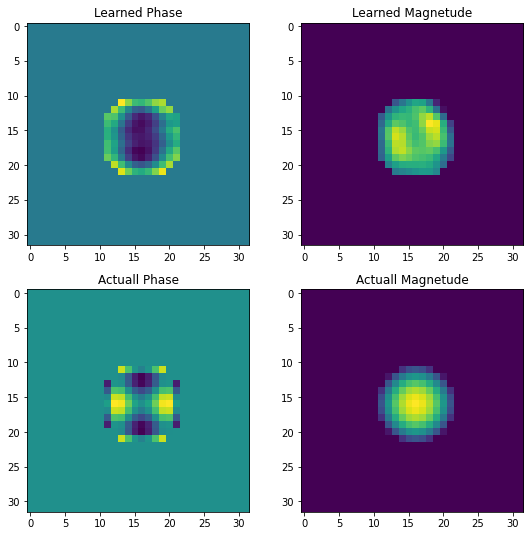

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))

ax[0,0].imshow(tmpPhase)
ax[0,0].set_title('Learned Phase')
ax[0,1].imshow(tmpMag)
ax[0,1].set_title('Learned Magnetude')
ax[1,1].imshow(tMag)
ax[1,1].set_title('Actuall Magnetude')
ax[1,0].imshow(tPhase)
ax[1,0].set_title('Actuall Phase')
plt.show()

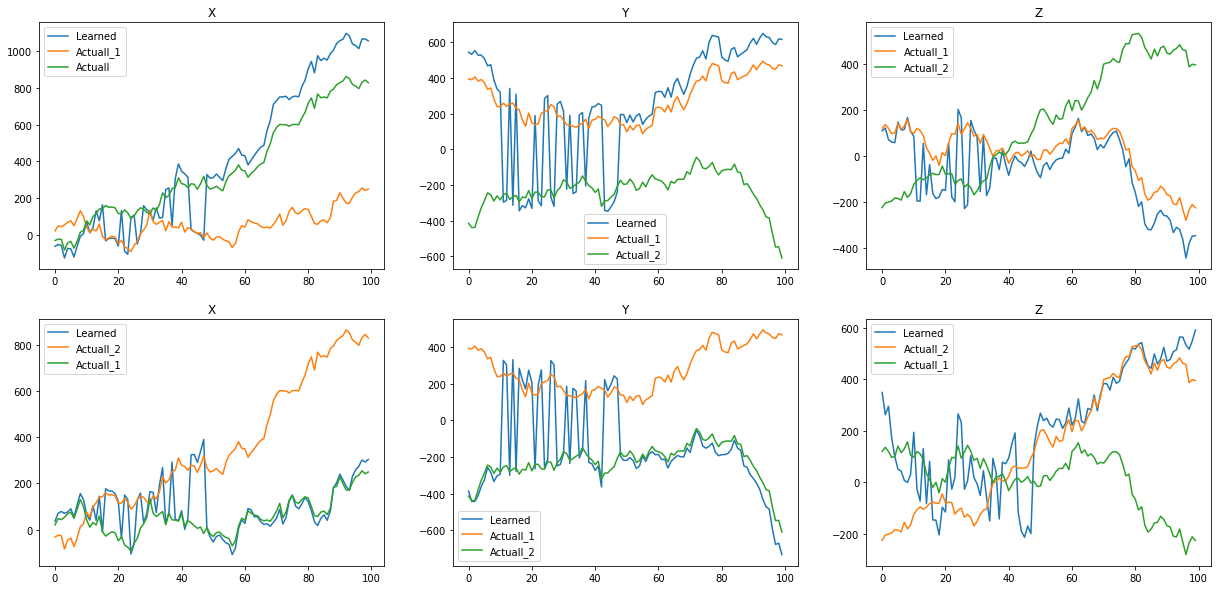

In [ ]:
XX = np.array(FoundX)
YY = np.array(FoundY)
ZZ = np.array(FoundZ)

fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax[0,0].plot(XX[:,0], label='Learned')
ax[0,0].plot(PSFstruct['X'][1],label='Actuall_1')
ax[0,0].plot(PSFstruct['X'][0],label='Actuall')
ax[0,0].set_title('X')
ax[0,0].legend()

ax[0,1].plot(YY[:,0], label='Learned')
ax[0,1].plot(PSFstruct['Y'][0],label='Actuall_1')
ax[0,1].plot(PSFstruct['Y'][1],label='Actuall_2')
ax[0,1].set_title('Y')
ax[0,1].legend()

ax[0,2].plot(ZZ[:,0]-1300, label='Learned')
ax[0,2].plot(PSFstruct['Z'][0],label='Actuall_1')
ax[0,2].plot(PSFstruct['Z'][1],label='Actuall_2')
ax[0,2].set_title('Z')
ax[0,2].legend()

ax[1,0].plot(XX[:,1], label='Learned')
ax[1,0].plot(PSFstruct['X'][0],label='Actuall_2')
ax[1,0].plot(PSFstruct['X'][1],label='Actuall_1')
ax[1,0].set_title('X')
ax[1,0].legend()

ax[1,1].plot(YY[:,1], label='Learned')
ax[1,1].plot(PSFstruct['Y'][0],label='Actuall_1')
ax[1,1].plot(PSFstruct['Y'][1],label='Actuall_2')
ax[1,1].set_title('Y')
ax[1,1].legend()

ax[1,2].plot(ZZ[:,1]-1300, label='Learned')
ax[1,2].plot(PSFstruct['Z'][1],label='Actuall_2')
ax[1,2].plot(PSFstruct['Z'][0],label='Actuall_1')
ax[1,2].set_title('Z')
ax[1,2].legend()

plt.savefig('/content/drive/My Drive/Two_particle.png')
plt.show()

#Fix trajectories

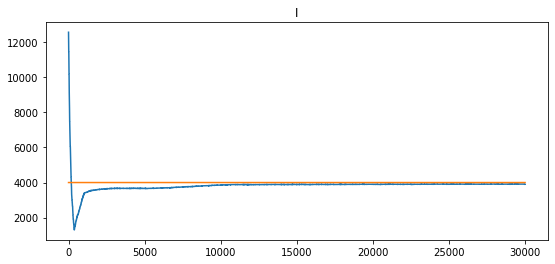

In [ ]:
I = np.load('/content/drive/My Drive/I_30.npy')
rbg1 = np.zeros(I.shape[0])+4000
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
kk=1
ax.plot(I[kk:])
ax.set_title('I')
ax.plot(rbg1[kk:])
plt.show()

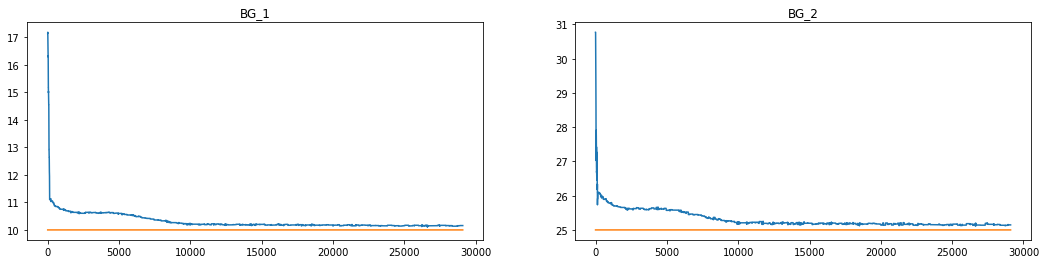

In [ ]:
Bg = np.load('/content/drive/My Drive/Bg_30.npy')
rbg1 = np.zeros(Bg.shape[0])+10
rbg2 = np.zeros(Bg.shape[0])+25
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
kk=900
ax[0].plot(Bg[kk:,0])
ax[0].set_title('BG_1')
ax[1].plot(Bg[kk:,1])
ax[1].set_title('BG_2')
ax[0].plot(rbg1[kk:])
ax[1].plot(rbg2[kk:])
plt.show()

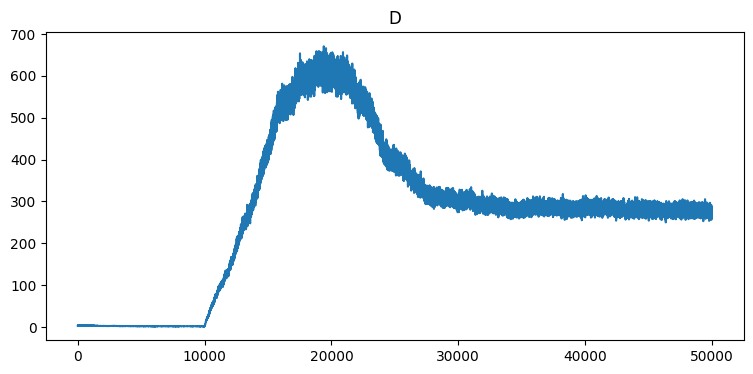

In [5]:
D = np.load('chains/chains1/D_1.npy')
# rbg1 = np.zeros(I.shape[0])+20
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
kk=1
ax.plot(D[kk:])
ax.set_title('D')
# ax.plot(rbg1[kk:])
plt.show()

In [ ]:
kk=3000
Phase = np.load('/content/drive/My Drive/Phase_30.npy')
tPhase = PSFstruct['Pupil_Phase']
Z0 = PSFstruct['ZImages'][:,:,0]
Zx = PSFstruct['ZImages'][:,:,1]
Zy = PSFstruct['ZImages'][:,:,2]
Zz = PSFstruct['ZImages'][:,:,3]
KPixelSize = 1/(PSFstruct['PixelSize']*PSFstruct['NPix'])
PupilRadius = PSFstruct['Na']/(PSFstruct['Lambda']*KPixelSize)
ADisk = pi*PupilRadius**2
Mask = PSFstruct['Mask']
tmpPhase = np.mean(Phase[-kk:],axis=0)
for ii in range(20):
    XShift = np.sum(tmpPhase*Zx*Mask)/ADisk
    YShift = np.sum(tmpPhase*Zy*Mask)/ADisk
    ZShift = np.sum(tmpPhase*Zz*Mask)/ADisk
    Offset = np.sum(tmpPhase*Z0*Mask)/ADisk
    tmpPhase = (tmpPhase - XShift*Zx - YShift*Zy - ZShift*Zz - Offset*Z0)*Mask


tMag=(PSFstruct['Pupil_Mag'])
tMag[Mask==0] = 100
tMag[Mask==0] = np.min(tMag)
Mag = np.load('/content/drive/My Drive/Mag_30.npy')
tmpMag = np.mean(Mag[-kk:],axis=0)
tmpMag[Mask==0] = 100
tmpMag[Mask==0] = np.min(tmpMag)

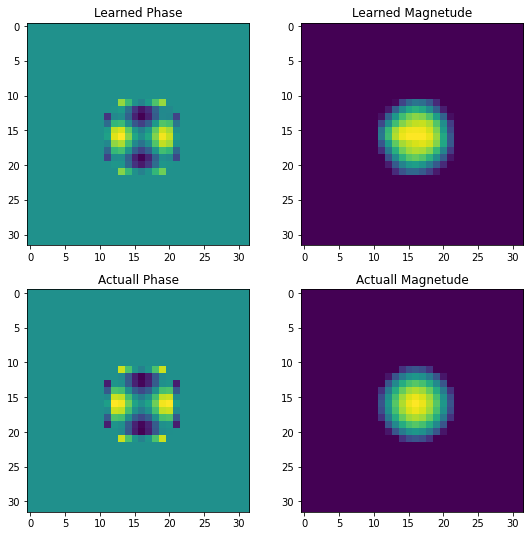

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))

ax[0,0].imshow(tmpPhase)
ax[0,0].set_title('Learned Phase')
ax[0,1].imshow(tmpMag)
ax[0,1].set_title('Learned Magnetude')
ax[1,1].imshow(tMag)
ax[1,1].set_title('Actuall Magnetude')
ax[1,0].imshow(tPhase)
ax[1,0].set_title('Actuall Phase')
plt.show()

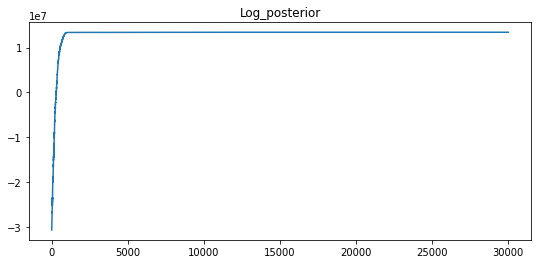

In [ ]:
post = np.load('/content/drive/My Drive/post_30.npy')
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
kk=1
ax.plot(post[kk:])
ax.set_title('Log_posterior')
# ax.plot(rbg1[kk:])
plt.show()

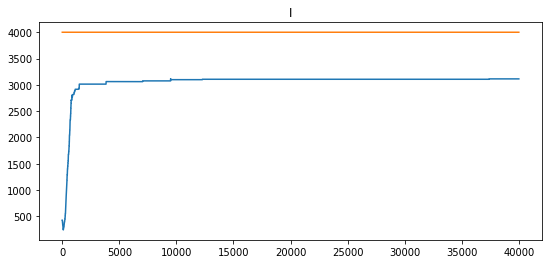

In [ ]:
I = np.load('/content/drive/My Drive/I_400.npy')
rbg1 = np.zeros(I.shape[0])+4000
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
kk=1
ax.plot(I[kk:])
ax.set_title('I')
ax.plot(rbg1[kk:])
plt.show()

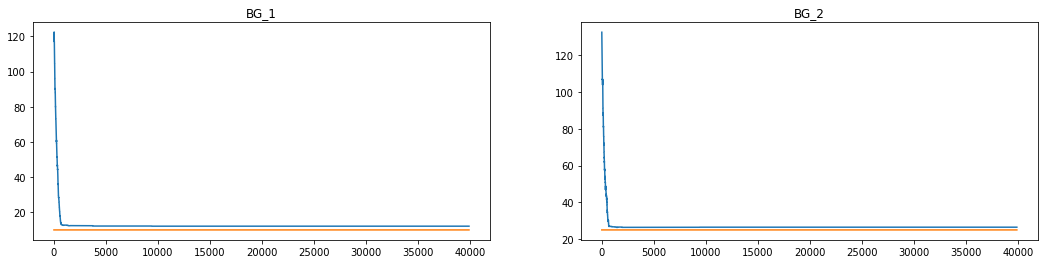

In [ ]:
Bg = np.load('/content/drive/My Drive/Bg_400.npy')
rbg1 = np.zeros(Bg.shape[0])+10
rbg2 = np.zeros(Bg.shape[0])+25
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
kk=100
ax[0].plot(Bg[kk:,0])
ax[0].set_title('BG_1')
ax[1].plot(Bg[kk:,1])
ax[1].set_title('BG_2')
ax[0].plot(rbg1[kk:])
ax[1].plot(rbg2[kk:])
plt.show()

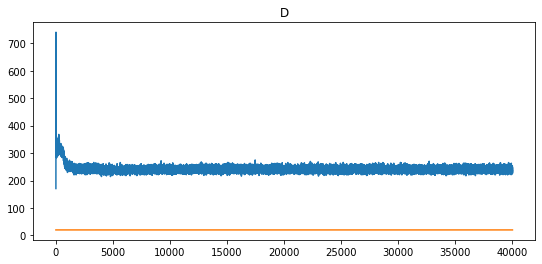

In [ ]:
D = np.load('/content/drive/My Drive/D_400.npy')
rbg1 = np.zeros(I.shape[0])+20
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
kk=1
ax.plot(D[kk:])
ax.set_title('D')
ax.plot(rbg1[kk:])
plt.show()

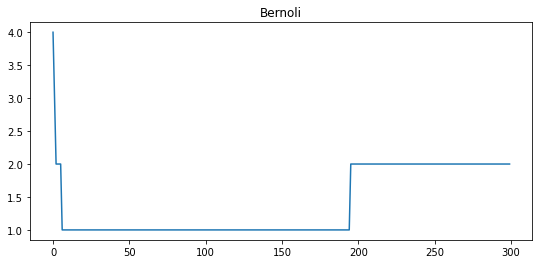

In [ ]:
B = np.load('/content/drive/My Drive/Bernolli_400.npy')[:,:40000]
B = np.sum(B,axis=0)
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.plot(B[:300])
ax.set_title('Bernoli')
plt.show()

In [ ]:
kk=35000
Phase = np.load('/content/drive/My Drive/SML_result/Phase_.npy')
tPhase = PSFstruct['Pupil_Phase']
Z0 = PSFstruct['ZImages'][:,:,0]
Zx = PSFstruct['ZImages'][:,:,1]
Zy = PSFstruct['ZImages'][:,:,2]
Zz = PSFstruct['ZImages'][:,:,3]
KPixelSize = 1/(PSFstruct['PixelSize']*PSFstruct['NPix'])
PupilRadius = PSFstruct['Na']/(PSFstruct['Lambda']*KPixelSize)
ADisk = pi*PupilRadius**2
Mask = PSFstruct['Mask']
tmpPhase = np.mean(Phase, axis=0)
for ii in range(20):
    XShift = np.sum(tmpPhase*Zx*Mask)/ADisk
    YShift = np.sum(tmpPhase*Zy*Mask)/ADisk
    ZShift = np.sum(tmpPhase*Zz*Mask)/ADisk
    Offset = np.sum(tmpPhase*Z0*Mask)/ADisk
    tmpPhase = (tmpPhase - XShift*Zx - YShift*Zy - ZShift*Zz - Offset*Z0)*Mask

tMag=(PSFstruct['Pupil_Mag'])
tMag[Mask==0] = 100
tMag[Mask==0] = np.min(tMag)
Mag = np.load('/content/drive/My Drive/SML_result/Mag_4.npy')
tmpMag = np.mean(Mag, axis=0)
tmpMag[Mask==0] = 100
tmpMag[Mask==0] = np.min(tmpMag)

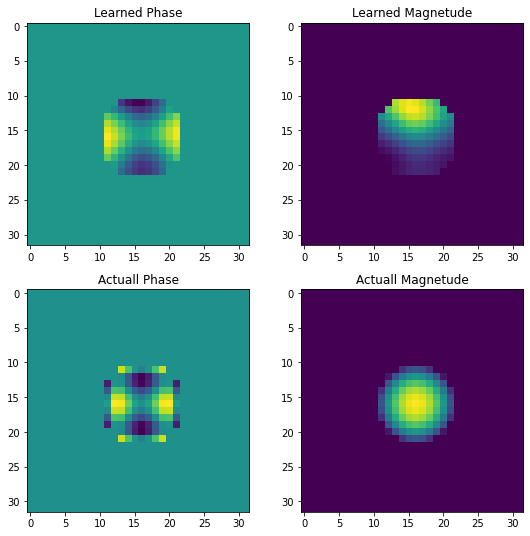

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))

ax[0,0].imshow(tmpPhase)
ax[0,0].set_title('Learned Phase')
ax[0,1].imshow(tmpMag)
ax[0,1].set_title('Learned Magnetude')
ax[1,1].imshow(tMag)
ax[1,1].set_title('Actuall Magnetude')
ax[1,0].imshow(tPhase)
ax[1,0].set_title('Actuall Phase')
plt.show()

In [13]:
# PSFstruct = np.load('/content/drive/My Drive/PSFstruct.npy', allow_pickle=True)[()]

XX = np.load('/home/reza/software/BNP_SMTM/code_data/chains/chains1/X_2.npy')
YY = np.load('/home/reza/software/BNP_SMTM/code_data/chains/chains1/Y_2.npy')
ZZ = np.load('/home/reza/software/BNP_SMTM/code_data/chains/chains1/Z_2.npy')
ZZ.shape

(1000, 100, 6)

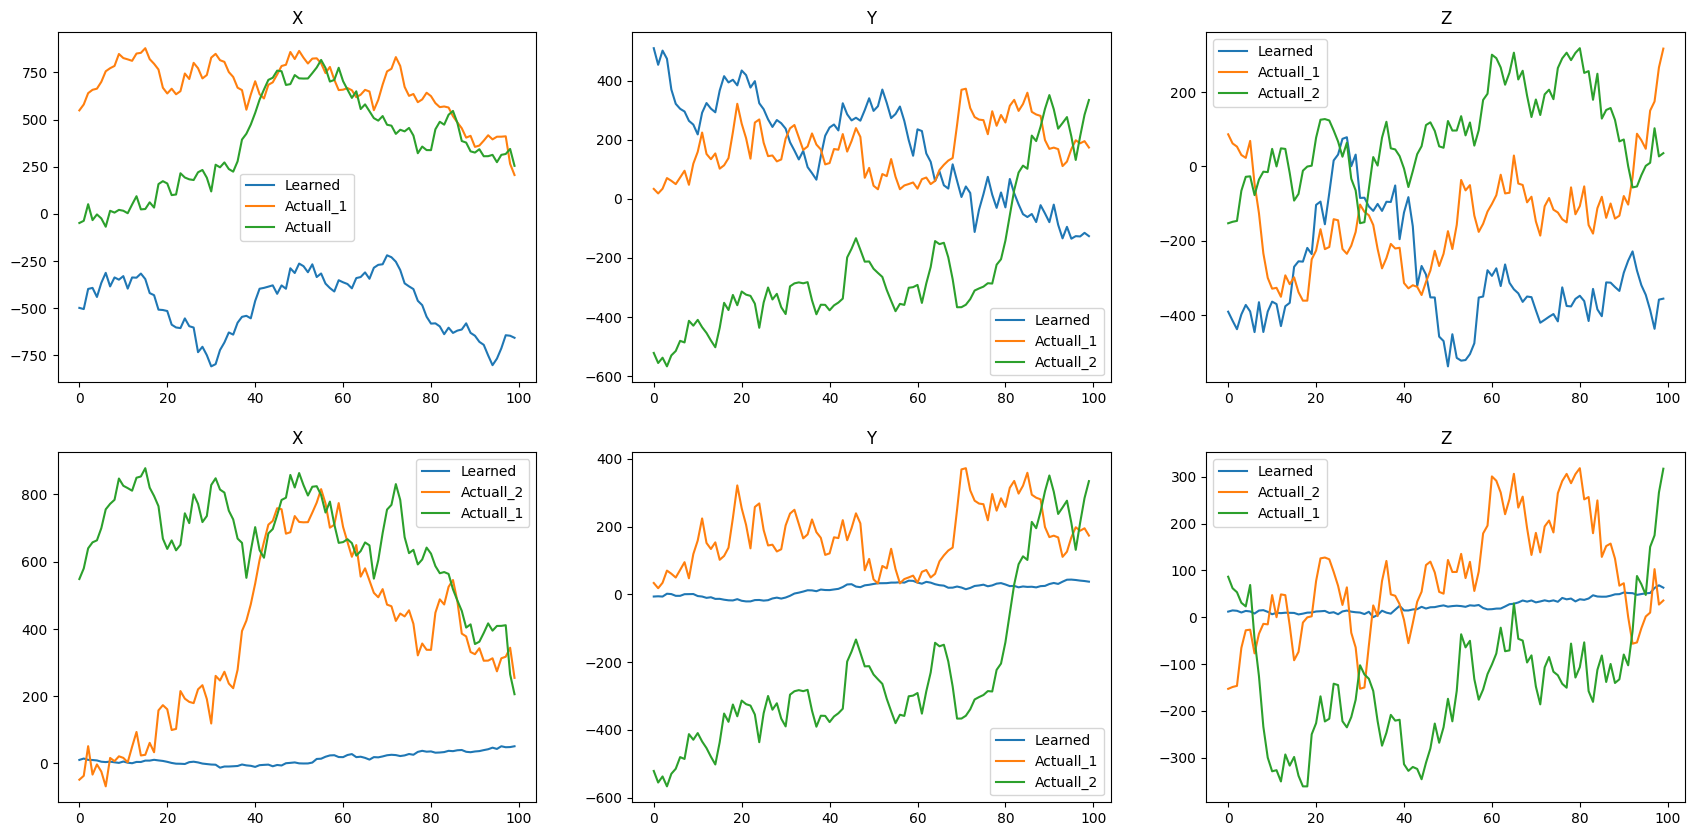

In [14]:

XX = np.mean(XX, axis=0)
YY = np.mean(YY, axis=0)
ZZ = np.mean(ZZ, axis=0)

fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax[0,0].plot(XX[:,0], label='Learned')
ax[0,0].plot(PSFstruct['X'][1],label='Actuall_1')
ax[0,0].plot(PSFstruct['X'][0],label='Actuall')
ax[0,0].set_title('X')
ax[0,0].legend()

ax[0,1].plot(YY[:,0], label='Learned')
ax[0,1].plot(PSFstruct['Y'][0],label='Actuall_1')
ax[0,1].plot(PSFstruct['Y'][1],label='Actuall_2')
ax[0,1].set_title('Y')
ax[0,1].legend()

ax[0,2].plot(ZZ[:,0], label='Learned')
ax[0,2].plot(PSFstruct['Z'][0],label='Actuall_1')
ax[0,2].plot(PSFstruct['Z'][1],label='Actuall_2')
ax[0,2].set_title('Z')
ax[0,2].legend()

ax[1,0].plot(XX[:,2], label='Learned')
ax[1,0].plot(PSFstruct['X'][0],label='Actuall_2')
ax[1,0].plot(PSFstruct['X'][1],label='Actuall_1')
ax[1,0].set_title('X')
ax[1,0].legend()

ax[1,1].plot(YY[:,2], label='Learned')
ax[1,1].plot(PSFstruct['Y'][0],label='Actuall_1')
ax[1,1].plot(PSFstruct['Y'][1],label='Actuall_2')
ax[1,1].set_title('Y')
ax[1,1].legend()

ax[1,2].plot(ZZ[:,2], label='Learned')
ax[1,2].plot(PSFstruct['Z'][1],label='Actuall_2')
ax[1,2].plot(PSFstruct['Z'][0],label='Actuall_1')
ax[1,2].set_title('Z')
ax[1,2].legend()

plt.show()

1
AxesSubplot(0.125,0.536818;0.775x0.343182)
2
AxesSubplot(0.125,0.125;0.775x0.343182)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.


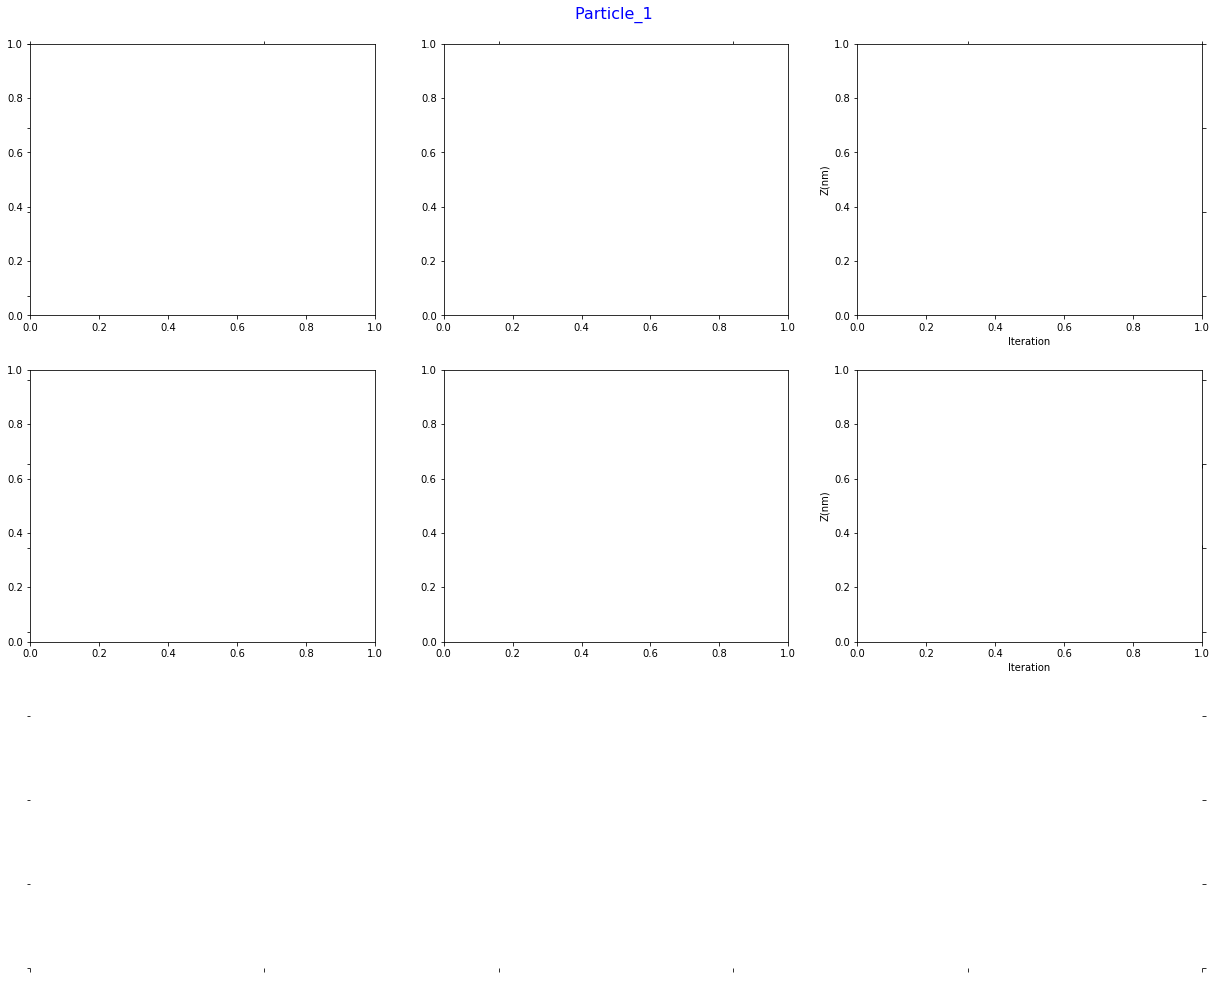

In [ ]:
fig, big_axes = plt.subplots( figsize=(21.0, 17.0) , nrows=2, ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(f"Particle_{row} \n" , color="blue", fontsize=16)
    print(row)
    print(big_ax)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False


for i in range(1,7):
    ax = fig.add_subplot(3,3,i)
    if not i%3:
        ax.set_ylabel("Z(nm)")
        ax.set_xlabel("Iteration")
    
fig.set_facecolor('w')
plt.tight_layout()
plt.show()

#after switch

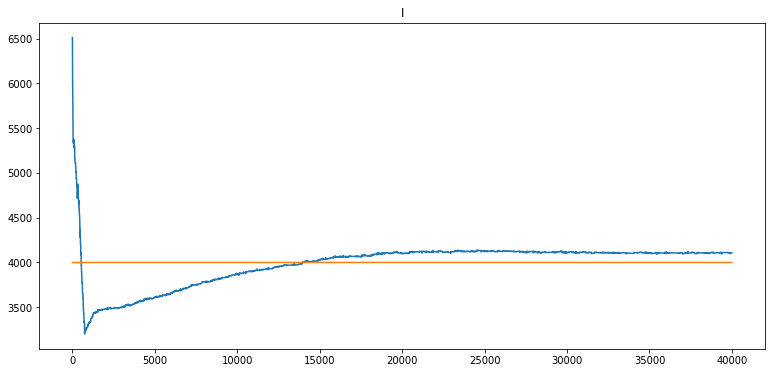

In [ ]:
I = np.load('/content/drive/My Drive/SML_result/I_4.0.npy')
rbg1 = np.zeros(I.shape[0])+4000
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
kk=1
ax.plot(I[kk:])
ax.set_title('I')
ax.plot(rbg1[kk:])
plt.show()

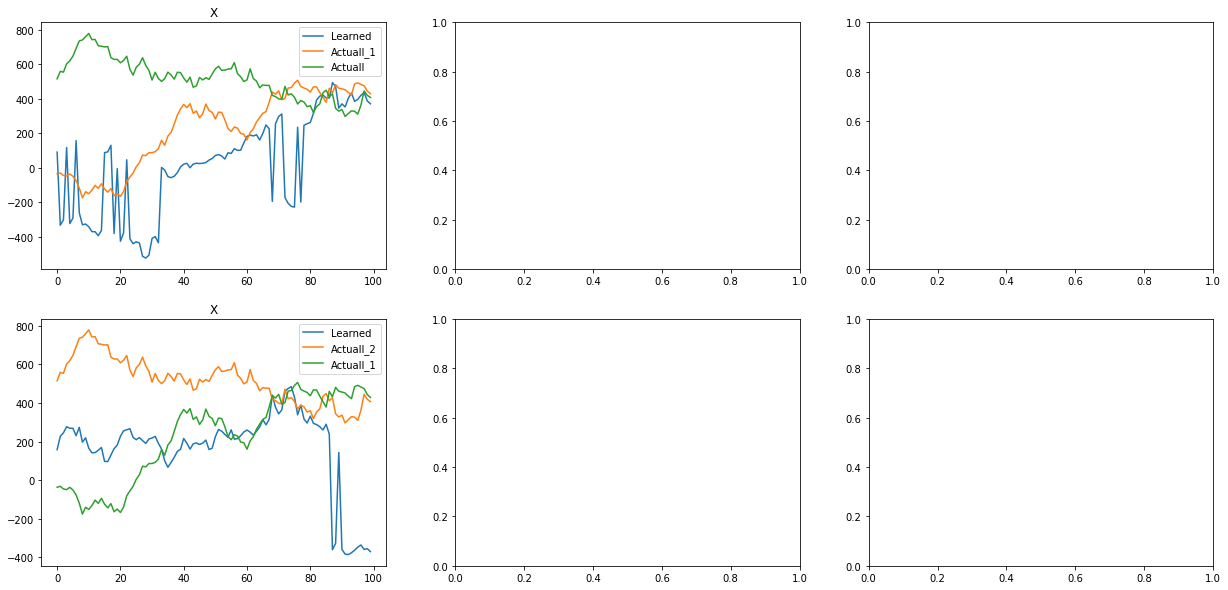

In [ ]:
PSFstruct = np.load('/content/drive/My Drive/PSFstruct_3RND.npy', allow_pickle=True)[()]

XX = np.load('/content/drive/My Drive/SML_result/X_50000 (1).npy')
YY = np.load('/content/drive/My Drive/SML_result/X_12.0.npy')
# ZZ = np.load('/content/drive/My Drive/SML_result/Z_4.0.npy')
k=20000
XX = np.mean(XX[-k:,:], axis=0)
YY = np.mean(YY, axis=0)
# ZZ = np.mean(ZZ, axis=0)

fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax[0,0].plot(XX[:,0], label='Learned')
ax[0,0].plot(PSFstruct['X'][1],label='Actuall_1')
ax[0,0].plot(PSFstruct['X'][0],label='Actuall')
ax[0,0].set_title('X')
ax[0,0].legend()

# ax[0,1].plot(YY[:,0], label='Learned')
# ax[0,1].plot(PSFstruct['Y'][0],label='Actuall_1')
# ax[0,1].plot(PSFstruct['Y'][1],label='Actuall_2')
# ax[0,1].set_title('Y')
# ax[0,1].legend()

# ax[0,2].plot(ZZ[:,0], label='Learned')
# ax[0,2].plot(PSFstruct['Z'][0],label='Actuall_1')
# ax[0,2].plot(PSFstruct['Z'][1],label='Actuall_2')
# ax[0,2].set_title('Z')
# ax[0,2].legend()

ax[1,0].plot(XX[:,2], label='Learned')
ax[1,0].plot(PSFstruct['X'][0],label='Actuall_2')
ax[1,0].plot(PSFstruct['X'][1],label='Actuall_1')
ax[1,0].set_title('X')
ax[1,0].legend()

# ax[1,1].plot(YY[:,2], label='Learned')
# ax[1,1].plot(PSFstruct['Y'][0],label='Actuall_1')
# ax[1,1].plot(PSFstruct['Y'][1],label='Actuall_2')
# ax[1,1].set_title('Y')
# ax[1,1].legend()

# ax[1,2].plot(ZZ[:,2], label='Learned')
# ax[1,2].plot(PSFstruct['Z'][1],label='Actuall_2')
# ax[1,2].plot(PSFstruct['Z'][0],label='Actuall_1')
# ax[1,2].set_title('Z')
# ax[1,2].legend()

plt.show()

In [ ]:
!kaggle competitions download -c mayo-clinic-strip-ai

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
 ! pip install -q kaggle

In [ ]:
PSFtype='AS'; D=20; Dt=20; NFrame=100; I=4000; Bg=[10,25]; Number=2; Scale=2
struct = np.load('/content/drive/My Drive/PSFstruct_2RND.npy', allow_pickle=True)
Data = np.load('/content/drive/My Drive/Data_2RND.npy')
PSFstruct = struct[()]

In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

def display_video(array):
    fig = plt.figure(figsize=(7,7))  #Display size specification

    mov = []
    for i in range(size(array, axis=2)):  #Append videos one by one to mov
        img = plt.imshow(array[:,:,i], animated=True)
        plt.axis('off')
        mov.append([img])

    #Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)

    plt.close()
    return anime

HTML(display_video(Data[:,:,:,1]).to_html5_video())  #Inline video display in HTML5

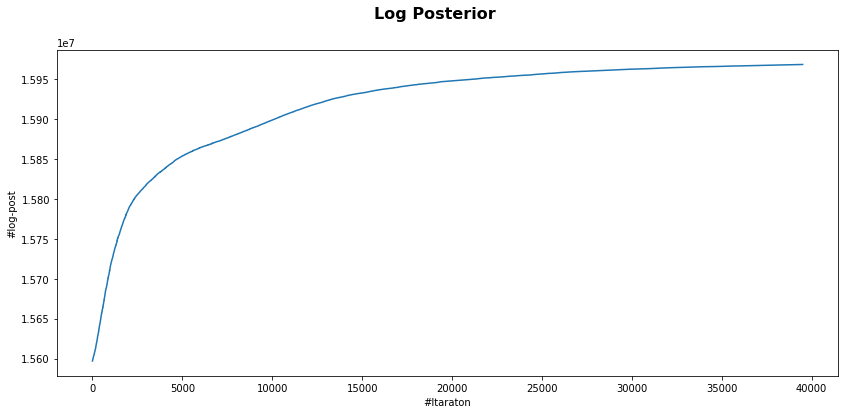

In [ ]:
D = np.load('/content/drive/My Drive/SML_result/Log_post_4.npy')
# rbg1 = np.zeros(D.shape)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
kk=500
ax.plot(D[kk:])
ax.set_xlabel("#Itaraton")
ax.set_ylabel("log-post")
fig.suptitle('Log Posterior', fontweight='bold', size=16)
plt.savefig("/content/drive/My Drive/SML_result/Log.png")
plt.show()

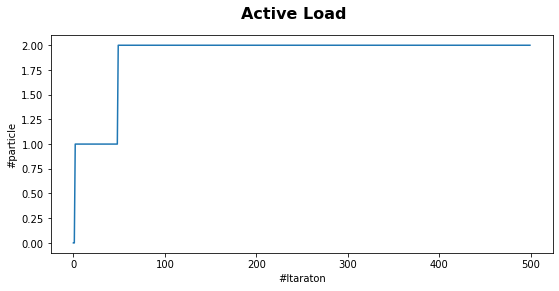

In [ ]:
B = np.load('/content/drive/My Drive/SML_result/bernoli_9.npy')
B = np.sum(B,axis=1)
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.plot(B[:500])
ax.set_xlabel("#Itaraton")
ax.set_ylabel("#particle")
fig.suptitle('Active Load', fontweight='bold', size=16)
plt.savefig("/content/drive/My Drive/SML_result/bernoli.png")
plt.show()

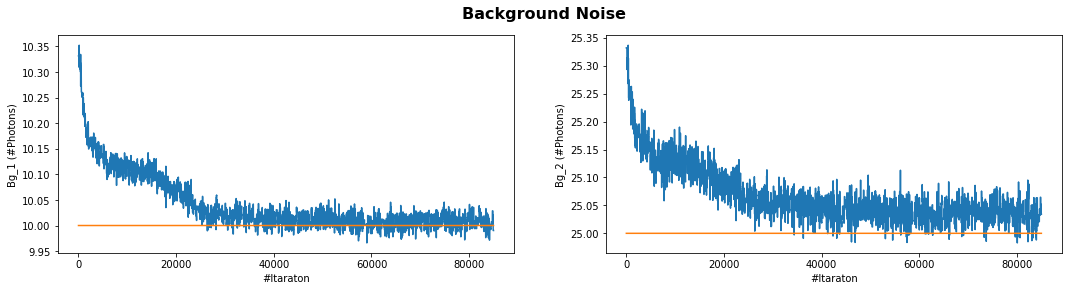

In [ ]:
Bg = np.load('/content/drive/My Drive/SML_result/Bg_9.npy')
rbg1 = np.zeros(Bg.shape[0])+10
rbg2 = np.zeros(Bg.shape[0])+25
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
kk=5000
ax[0].plot(Bg[kk:,0])
ax[1].plot(Bg[kk:,1])
ax[0].plot(rbg1[kk:])
ax[1].plot(rbg2[kk:])
ax[0].set_ylabel("Bg_1 (#Photons)")
ax[0].set_xlabel("#Itaraton")
ax[1].set_xlabel("#Itaraton")
ax[1].set_ylabel("Bg_2 (#Photons)")
fig.suptitle('Background Noise', fontweight='bold', size=16)
plt.savefig("/content/drive/My Drive/SML_result/BG.png")
plt.show()

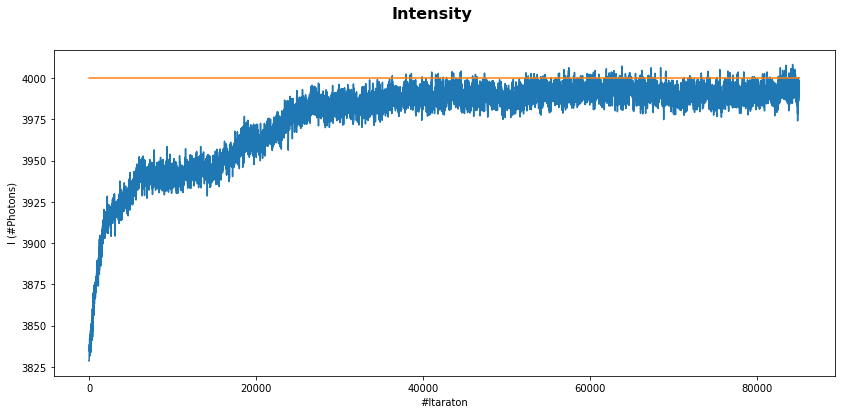

In [ ]:
I = np.load('/content/drive/My Drive/SML_result/I_9.npy')
rbg1 = np.zeros(I.shape)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
kk=5000
ax.plot(I[kk:])
ax.plot(rbg1[kk:]+4000)
ax.set_xlabel("#Itaraton")
ax.set_ylabel("I (#Photons)")
fig.suptitle('Intensity', fontweight='bold', size=16)
plt.savefig("/content/drive/My Drive/SML_result/Int.png")
plt.show()

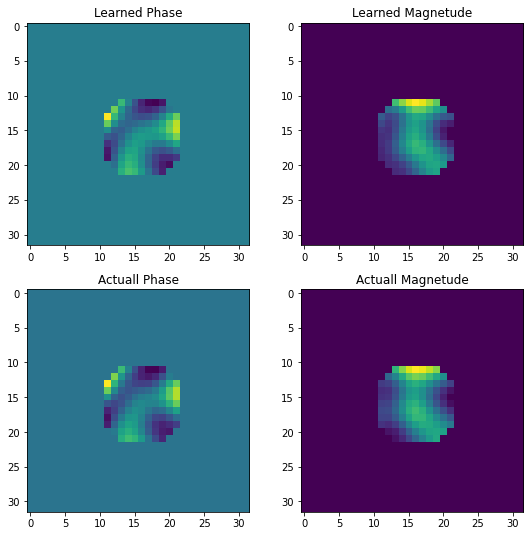

In [ ]:
Phase = np.load('/content/drive/My Drive/SML_result/Phase_9.npy')
tPhase = PSFstruct['Pupil_Phase']
Z0 = PSFstruct['ZImages'][:,:,0]
Zx = PSFstruct['ZImages'][:,:,1]
Zy = PSFstruct['ZImages'][:,:,2]
Zz = PSFstruct['ZImages'][:,:,3]
KPixelSize = 1/(PSFstruct['PixelSize']*PSFstruct['NPix'])
PupilRadius = PSFstruct['Na']/(PSFstruct['Lambda']*KPixelSize)
ADisk = pi*PupilRadius**2
Mask = PSFstruct['Mask']
tmpPhase = np.mean(Phase,axis=0)
for ii in range(20):
    XShift = np.sum(tmpPhase*Zx*Mask)/ADisk
    YShift = np.sum(tmpPhase*Zy*Mask)/ADisk
    ZShift = np.sum(tmpPhase*Zz*Mask)/ADisk
    Offset = np.sum(tmpPhase*Z0*Mask)/ADisk
    tmpPhase = (tmpPhase - XShift*Zx - YShift*Zy - ZShift*Zz - Offset*Z0)*Mask


tMag=(PSFstruct['Pupil_Mag'])
tMag[Mask==0] = 100
tMag[Mask==0] = np.min(tMag)
Mag = np.load('/content/drive/My Drive/SML_result/Mag_9.npy')
tmpMag = np.mean(Mag,axis=0)
tmpMag[Mask==0] = 100
tmpMag[Mask==0] = np.min(tmpMag)

fig, ax = plt.subplots(2, 2, figsize=(9, 9))

ax[0,0].imshow(tmpPhase)
ax[0,0].set_title('Learned Phase')
ax[0,1].imshow(tmpMag)
ax[0,1].set_title('Learned Magnetude')
ax[1,1].imshow(tMag)
ax[1,1].set_title('Actuall Magnetude')
ax[1,0].imshow(tPhase)
ax[1,0].set_title('Actuall Phase')
plt.savefig("/content/drive/My Drive/SML_result/phase_mag.png")
plt.show()

In [ ]:
XX = np.load('/content/drive/My Drive/SML_result/X_9.npy')
YY = np.load('/content/drive/My Drive/SML_result/Y_9.npy')
ZZ = np.load('/content/drive/My Drive/SML_result/Z_9.npy')
XX = np.mean(XX, axis=0)
YY = np.mean(YY, axis=0)
ZZ = np.mean(ZZ, axis=0)

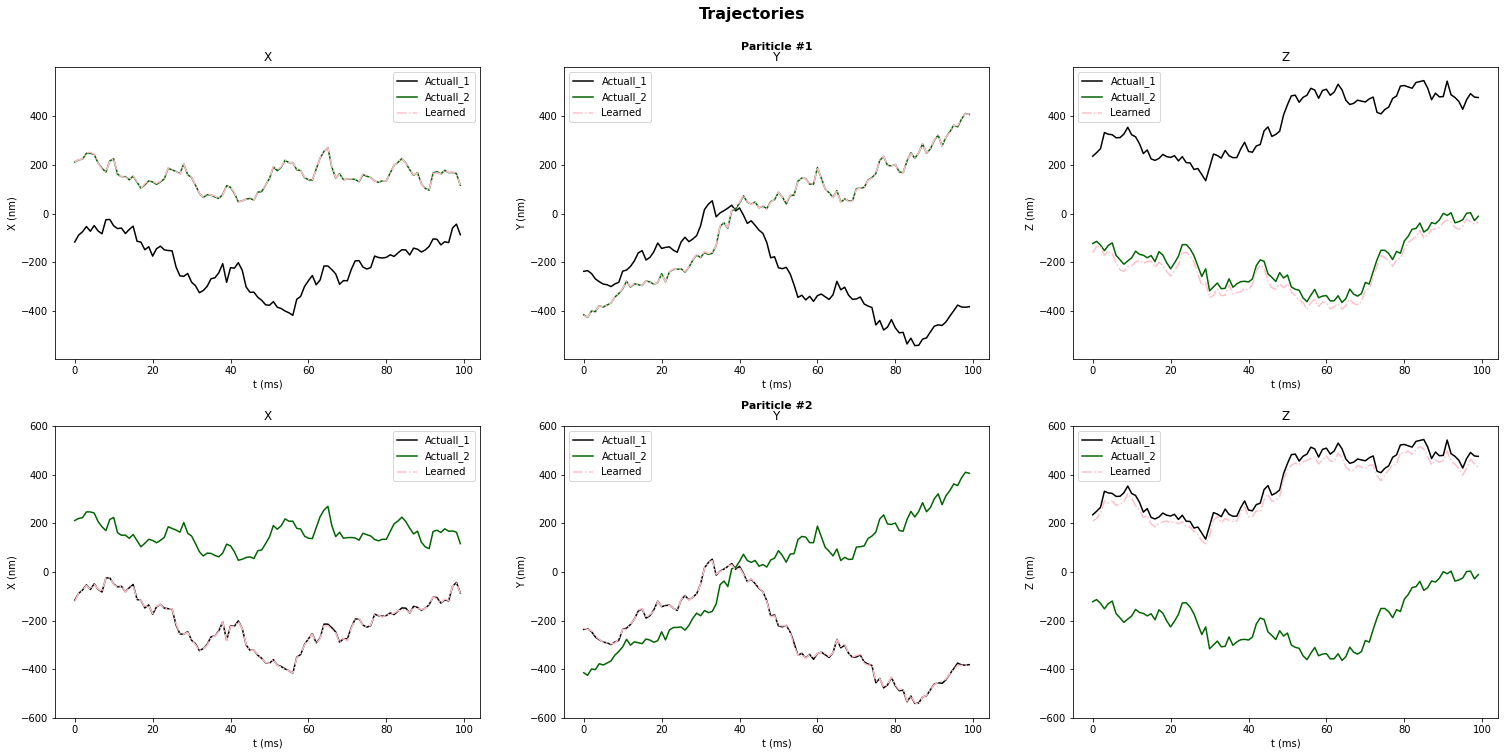

In [ ]:
rows = 2
cols = 1

fig = plt.figure(figsize=(21, 11))
# grid for pairs of subplots
grid = plt.GridSpec(rows, cols)

for i in range(rows * cols):
    # create fake subplot just to title set of subplots
    fake = fig.add_subplot(grid[i])
    # '\n' is important
    fake.set_title(f'Pariticle #{i+1}\n', fontweight='semibold', size=11)
    fake.set_axis_off()

    # create subgrid for two subplots without space between them
    # <https://matplotlib.org/2.0.2/users/gridspec.html>
    gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=grid[i])

    # real subplot #1
    ax = fig.add_subplot(gs[0])
    ax.plot(PSFstruct['X'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['X'][1], color = "darkgreen", label='Actuall_2')
    # ax.plot(PSFstruct['X'][2], color = "darkblue", label='Actuall_3')
    ax.plot(XX[:,i], '-.', color = "pink", label='Learned')
    ax.set_title('X')
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("X (nm)")
    ax.legend()

    # real subplot #2
    ax = fig.add_subplot(gs[1], sharey=ax)
    ax.plot(PSFstruct['Y'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['Y'][1], color = "darkgreen", label='Actuall_2')
    # ax.plot(PSFstruct['Y'][2], color = "darkblue", label='Actuall_3')
    ax.plot(YY[:,i], '-.', color = "pink", label='Learned')
    ax.set_title('Y')
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Y (nm)")
    ax.legend()
    
    # real subplot #3
    ax = fig.add_subplot(gs[2], sharey=ax)
    ax.plot(PSFstruct['Z'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['Z'][1], color = "darkgreen", label='Actuall_2')
    # ax.plot(PSFstruct['Z'][2], color = "darkblue", label='Actuall_3')
    ax.plot(ZZ[:,i], '-.', color = "pink", label='Learned')
    ax.set_title('Z')
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Z (nm)")
    ax.legend()

fig.patch.set_facecolor('white')
fig.suptitle('Trajectories', fontweight='bold', size=16)
plt.savefig("/content/drive/My Drive/SML_result/traj.png")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
D = np.load('/content/drive/My Drive/SML_result/D_9.npy')
rbg1 = np.zeros(D.shape)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
kk=20000
ax.plot(D[kk:])
ax.plot(rbg1[kk:]+20)
ax.set_xlabel("#Itaraton")
ax.set_ylabel("D (nm^2/ms)")
fig.suptitle('Diffusion coeficent', fontweight='bold', size=16)
plt.savefig("/content/drive/My Drive/SML_result/D.png")
plt.show()

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
PSFtype='AS'; D=20; Dt=20; NFrame=100; I=4000; Bg=[10,25]; Number=2; Scale=2
struct = np.load('/content/drive/My Drive/PSFstruct_3RND.npy', allow_pickle=True)
Data = np.load('/content/drive/My Drive/Data_3RND.npy')
PSFstruct = struct[()]

In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

def display_video(array):
    fig = plt.figure(figsize=(7,7))  #Display size specification

    mov = []
    for i in range(size(array, axis=2)):  #Append videos one by one to mov
        img = plt.imshow(array[:,:,i], animated=True)
        plt.axis('off')
        mov.append([img])

    #Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)

    plt.close()
    return anime

HTML(display_video(Data[:,:,:,1]).to_html5_video())  #Inline video display in HTML5

In [60]:
D = np.load('./gr61/Log_post_6.npy')
rbg1 = np.zeros(D.shape)+23031890.653924856

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
kk=500
ax.plot(D[kk:])
ax.plot(rbg1[kk:])
ax.set_xlabel("#Itaraton")
ax.set_ylabel("log-post")
fig.suptitle('Log Posterior', fontweight='bold', size=16)
# plt.savefig("./gr7/LogP.png")
print(f'last_step_posterior = {D[-1]}')
print(f'grand_truth_posterior = {rbg1[-1]}')
plt.show()

last_step_posterior = 22935760.219033103
grand_truth_posterior = 23031890.653924856


In [65]:
Phase = np.load('./gr61/Phase_6.npy')
tPhase = PSFstruct['Pupil_Phase']
Z0 = PSFstruct['ZImages'][:,:,0]
Zx = PSFstruct['ZImages'][:,:,1]
Zy = PSFstruct['ZImages'][:,:,2]
Zz = PSFstruct['ZImages'][:,:,3]
KPixelSize = 1/(PSFstruct['PixelSize']*PSFstruct['NPix'])
PupilRadius = PSFstruct['Na']/(PSFstruct['Lambda']*KPixelSize)
ADisk = pi*PupilRadius**2
Mask = PSFstruct['Mask']
tmpPhase = np.mean(Phase,axis=0)
for ii in range(20):
    XShift = np.sum(tmpPhase*Zx*Mask)/ADisk
    YShift = np.sum(tmpPhase*Zy*Mask)/ADisk
    ZShift = np.sum(tmpPhase*Zz*Mask)/ADisk
    Offset = np.sum(tmpPhase*Z0*Mask)/ADisk
    tmpPhase = (tmpPhase - XShift*Zx - YShift*Zy - ZShift*Zz - Offset*Z0)*Mask


tMag=(PSFstruct['Pupil_Mag'])
tMag[Mask==0] = 100
tMag[Mask==0] = np.min(tMag)
Mag = np.load('./gr61/Mag_6.npy')
tmpMag = np.mean(Mag,axis=0)
tmpMag[Mask==0] = 100
tmpMag[Mask==0] = np.min(tmpMag)

fig, ax = plt.subplots(2, 2, figsize=(9, 9))

ax[0,0].imshow(tmpPhase)
ax[0,0].set_title('Learned Phase')
ax[0,1].imshow(tmpMag)
ax[0,1].set_title('Learned Magnetude')
ax[1,1].imshow(tMag)
ax[1,1].set_title('Magnetude Ground Truth')
ax[1,0].imshow(tPhase)
ax[1,0].set_title('Phase Ground Truth' )
# plt.savefig("./gr7/phase_mag6.png")
plt.show()

In [5]:
kk=50
XX = np.load('./gr6/X_2.npy')
YY = np.load('./gr6/Y_2.npy')
ZZ = np.load('./gr6/Z_2.npy')
XX = np.mean(XX[-kk:,:,:], axis=0)
YY = np.mean(YY[-kk:,:,:], axis=0)
ZZ = np.mean(ZZ[-kk:,:,:], axis=0)

In [6]:
rows = 6
cols = 1

fig = plt.figure(figsize=(21, 40))
# grid for pairs of subplots
grid = plt.GridSpec(rows, cols)

for i in range(rows * cols):
    # create fake subplot just to title set of subplots
    fake = fig.add_subplot(grid[i])
    # '\n' is important
    fake.set_title(f'Pariticle #{i+1}\n', fontweight='semibold', size=11)
    fake.set_axis_off()

    # create subgrid for two subplots without space between them
    # <https://matplotlib.org/2.0.2/users/gridspec.html>
    gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=grid[i])

    # real subplot #1
    ax = fig.add_subplot(gs[0])
    ax.plot(PSFstruct['X'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['X'][1], color = "darkgreen", label='Actuall_2')
    ax.plot(PSFstruct['X'][2], color = "darkblue", label='Actuall_3')
    ax.plot(XX[:,i], '-.', color = "red", label='Learned')
    ax.set_title('X')
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("X (nm)")
    ax.legend()

    # real subplot #2
    ax = fig.add_subplot(gs[1], sharey=ax)
    ax.plot(PSFstruct['Y'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['Y'][1], color = "darkgreen", label='Actuall_2')
    ax.plot(PSFstruct['Y'][2], color = "darkblue", label='Actuall_3')
    ax.plot(YY[:,i], '-.', color = "red", label='Learned')
    ax.set_title('Y')
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Y (nm)")
    ax.legend()
    
    # real subplot #3
    ax = fig.add_subplot(gs[2], sharey=ax)
    ax.plot(PSFstruct['Z'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['Z'][1], color = "darkgreen", label='Actuall_2')
    ax.plot(PSFstruct['Z'][2], color = "darkblue", label='Actuall_3')
    ax.plot(ZZ[:,i], '-.', color = "red", label='Learned')
    ax.set_title('Z')
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Z (nm)")
    ax.legend()

fig.patch.set_facecolor('white')
fig.suptitle('Trajectories', fontweight='bold', size=16)
# plt.savefig("./gr7/traj.png")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [68]:
from matplotlib import gridspec

In [15]:
I = np.load('./gr61/I_6.npy')
rbg1 = np.zeros(I.shape)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
kk=500
ax.plot(I[kk:], label='Learned')
ax.plot(rbg1[kk:]+4000, label='ground truth')
ax.set_xlabel("#Itaraton")
ax.set_ylabel("I (#Photons)")
ax.legend()
fig.suptitle('Intensity', fontweight='bold', size=16)
# plt.savefig("./gr7/I.png")
plt.show()

In [78]:
B = np.load('./gr61/bernoli_6.npy')
print(B[-1])
B = np.sum(B,axis=1)
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.plot(B[:1300])
ax.set_xlabel("#Itaraton")
ax.set_ylabel("#particle")
fig.suptitle('Active Load', fontweight='bold', size=16)
plt.savefig("./gr61/load.png")
plt.show()


[1. 0. 0. 1. 0. 1.]


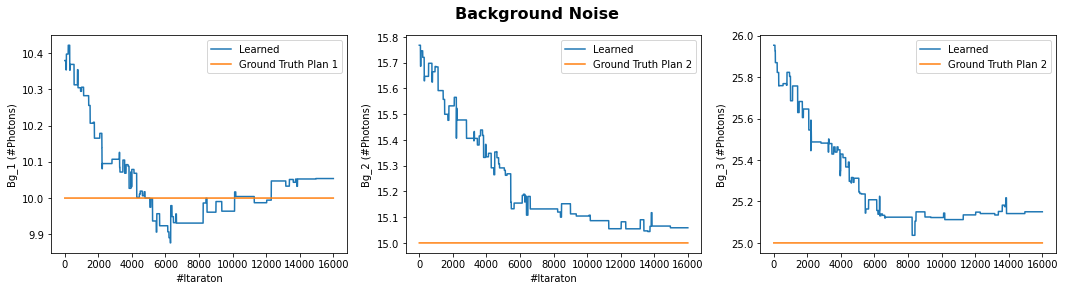

In [81]:
Bg = np.load('./gr61/Bg_6.npy')
rbg1 = np.zeros(Bg.shape[0])+10
rbg2 = np.zeros(Bg.shape[0])+15
rbg3 = np.zeros(Bg.shape[0])+25
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
kk=8000
ax[0].plot(Bg[kk:,0], label='Learned')
ax[1].plot(Bg[kk:,1], label='Learned')
ax[2].plot(Bg[kk:,2], label='Learned')
ax[0].plot(rbg1[kk:], label='Ground Truth Plan 1')
ax[1].plot(rbg2[kk:], label='Ground Truth Plan 2')
ax[2].plot(rbg3[kk:], label='Ground Truth Plan 2')
ax[0].set_ylabel("Bg_1 (#Photons)")
ax[0].set_xlabel("#Itaraton")
ax[1].set_xlabel("#Itaraton")
ax[1].set_ylabel("Bg_2 (#Photons)")
ax[1].set_xlabel("#Itaraton")
ax[2].set_ylabel("Bg_3 (#Photons)")
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.suptitle('Background Noise', fontweight='bold', size=16)
plt.savefig("./gr61/BG.png")
plt.show()

In [9]:
D = np.load('./gr6/Log_post_2.npy')
rbg1 = np.zeros(D.shape)+23031890.653924856
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
kk=2000
ax.plot(D[kk:])
ax.plot(rbg1[kk:])
ax.set_xlabel("#Itaraton")
ax.set_ylabel("log-post")
fig.suptitle('Log Posterior', fontweight='bold', size=16)
print(f'last_step_posterior = {D[-1]}')
print(f'grand_truth_posterior = {rbg1[-1]}')
plt.show()

last_step_posterior = 23030002.984569505
grand_truth_posterior = 23031890.653924856


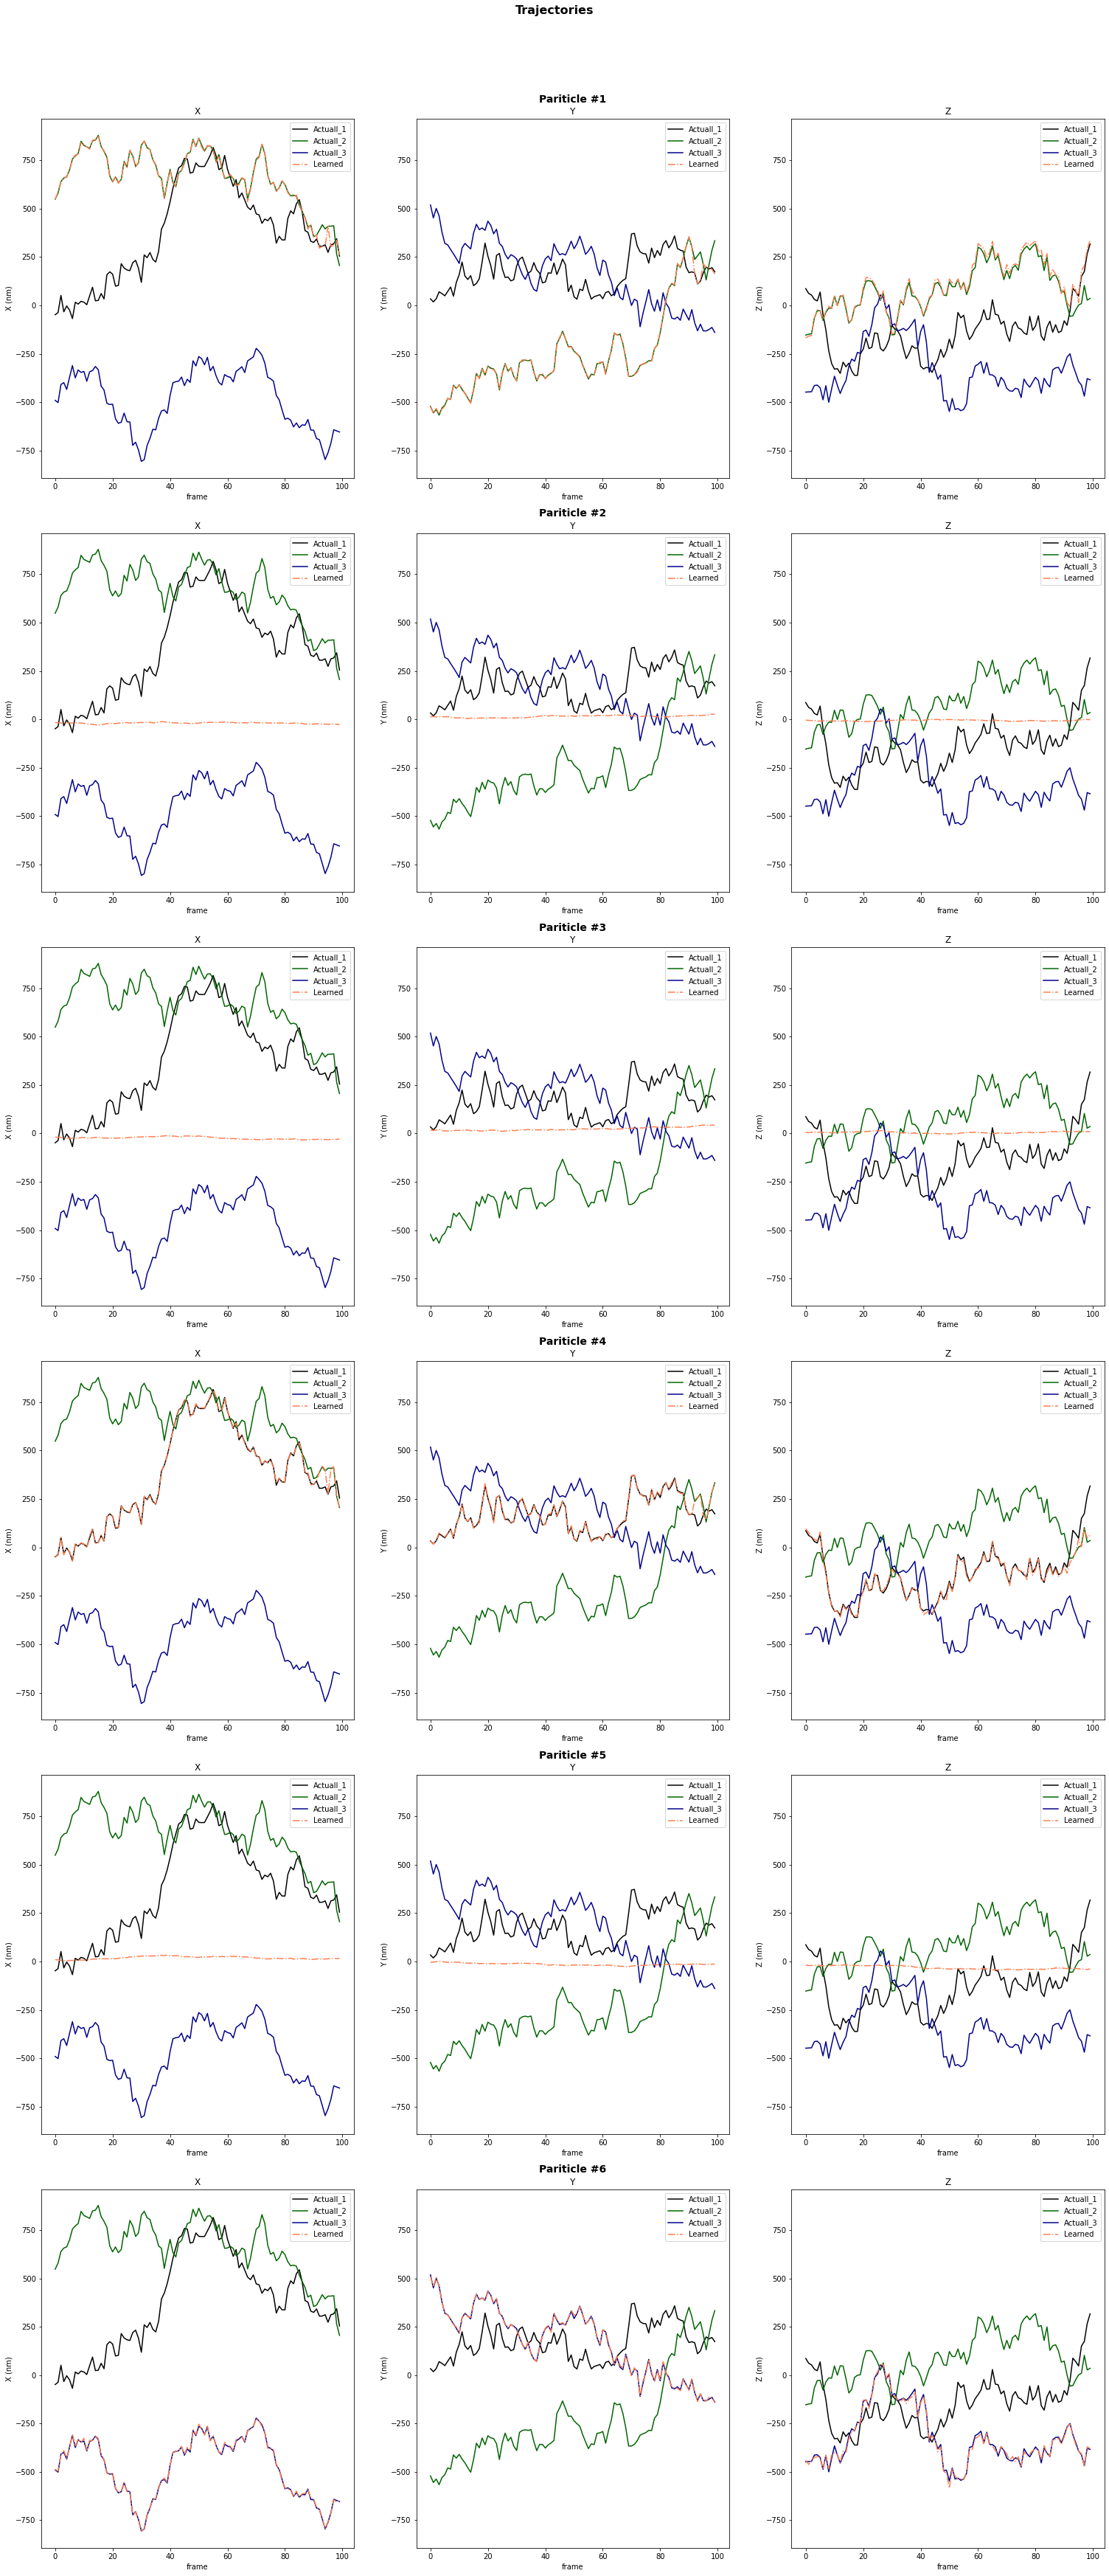

In [7]:
kk=1000
XX = np.load('./gr6/X_2.npy')
YY = np.load('./gr6/Y_2.npy')
ZZ = np.load('./gr6/Z_2.npy')
# print(f"xx = {XX.shape}")
XX = np.mean(XX[-kk:,:,:], axis=0)
YY = np.mean(YY[-kk:,:,:], axis=0)
ZZ = np.mean(ZZ[-kk:,:,:], axis=0)
rows = 6
cols = 1

fig = plt.figure(figsize=(21, 51))
# grid for pairs of subplots
grid = plt.GridSpec(rows, cols)

for i in range(rows * cols):
    # create fake subplot just to title set of subplots
    fake = fig.add_subplot(grid[i])
    # '\n' is important
    fake.set_title(f'Pariticle #{i+1}\n', fontweight='semibold', size=14)
    fake.set_axis_off()

    # create subgrid for two subplots without space between them
    # <https://matplotlib.org/2.0.2/users/gridspec.html>
    gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=grid[i])

    # real subplot #1
    ax = fig.add_subplot(gs[0])
    ax.plot(PSFstruct['X'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['X'][1], color = "darkgreen", label='Actuall_2')
    ax.plot(PSFstruct['X'][2], color = "darkblue", label='Actuall_3')
    ax.plot(XX[:,i], '-.', color = "coral", label='Learned')
    ax.set_title('X')
    ax.set_xlabel("frame")
    ax.set_ylabel("X (nm)")
    ax.legend()

    # real subplot #2
    ax = fig.add_subplot(gs[1], sharey=ax)
    ax.plot(PSFstruct['Y'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['Y'][1], color = "darkgreen", label='Actuall_2')
    ax.plot(PSFstruct['Y'][2], color = "darkblue", label='Actuall_3')
    ax.plot(YY[:,i], '-.', color = "coral", label='Learned')
    ax.set_title('Y')
    ax.set_xlabel("frame")
    ax.set_ylabel("Y (nm)")
    ax.legend()
    
    # real subplot #3
    ax = fig.add_subplot(gs[2], sharey=ax)
    ax.plot(PSFstruct['Z'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['Z'][1], color = "darkgreen", label='Actuall_2')
    ax.plot(PSFstruct['Z'][2], color = "darkblue", label='Actuall_3')
    ax.plot(ZZ[:,i], '-.', color = "coral", label='Learned')
    ax.set_title('Z')
    ax.set_xlabel("frame")
    ax.set_ylabel("Z (nm)")
    ax.legend()

fig.patch.set_facecolor('white')
fig.suptitle('Trajectories', fontweight='bold', size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plt.savefig("/content/drive/My Drive/SML_result/traj3.png")
plt.show()

In [6]:
Phase = np.load('./gr6/Phase_2.npy')
tPhase = PSFstruct['Pupil_Phase']
Z0 = PSFstruct['ZImages'][:,:,0]
Zx = PSFstruct['ZImages'][:,:,1]
Zy = PSFstruct['ZImages'][:,:,2]
Zz = PSFstruct['ZImages'][:,:,3]
KPixelSize = 1/(PSFstruct['PixelSize']*PSFstruct['NPix'])
PupilRadius = PSFstruct['Na']/(PSFstruct['Lambda']*KPixelSize)
ADisk = pi*PupilRadius**2
Mask = PSFstruct['Mask']
tmpPhase = np.mean(Phase,axis=0)
for ii in range(30):
    XShift = np.sum(tmpPhase*Zx*Mask)/ADisk
    YShift = np.sum(tmpPhase*Zy*Mask)/ADisk
    ZShift = np.sum(tmpPhase*Zz*Mask)/ADisk
    Offset = np.sum(tmpPhase*Z0*Mask)/ADisk
    tmpPhase = (tmpPhase - XShift*Zx - YShift*Zy - ZShift*Zz - Offset*Z0)*Mask


tMag=(PSFstruct['Pupil_Mag'])
tMag[Mask==0] = 100
tMag[Mask==0] = np.min(tMag)
Mag = np.load('./gr6/Mag_2.npy')
tmpMag = np.mean(Mag,axis=0)
tmpMag[Mask==0] = 100
tmpMag[Mask==0] = np.min(tmpMag)

fig, ax = plt.subplots(2, 2, figsize=(9, 9))

ax[0,0].imshow(tmpPhase)
ax[0,0].set_title('Learned Phase')
ax[0,1].imshow(tmpMag)
ax[0,1].set_title('Learned Magnetude')
ax[1,1].imshow(tMag)
ax[1,1].set_title('Magnetude Ground Truth')
ax[1,0].imshow(tPhase)
ax[1,0].set_title('Phase Ground Truth' )
# plt.savefig("./gr6/phase_mag6.png")
plt.show()

No handles with labels found to put in legend.


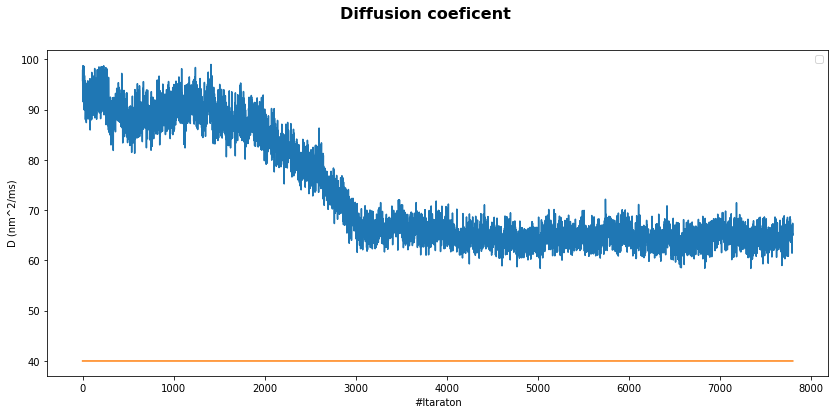

In [4]:
D = np.load('./gr6/D_2.npy')
rbg1 = np.zeros(D.shape)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
kk=200
ax.plot(D[kk:])
ax.plot(rbg1[kk:]+40,)
ax.set_xlabel("#Itaraton")
ax.set_ylabel("D (nm^2/ms)")
ax.legend()
fig.suptitle('Diffusion coeficent', fontweight='bold', size=16)
# plt.savefig("./gr7/D.png")
plt.show()

last_step_posterior = 22976319.626456507
grand_truth_posterior = 23031890.653924856


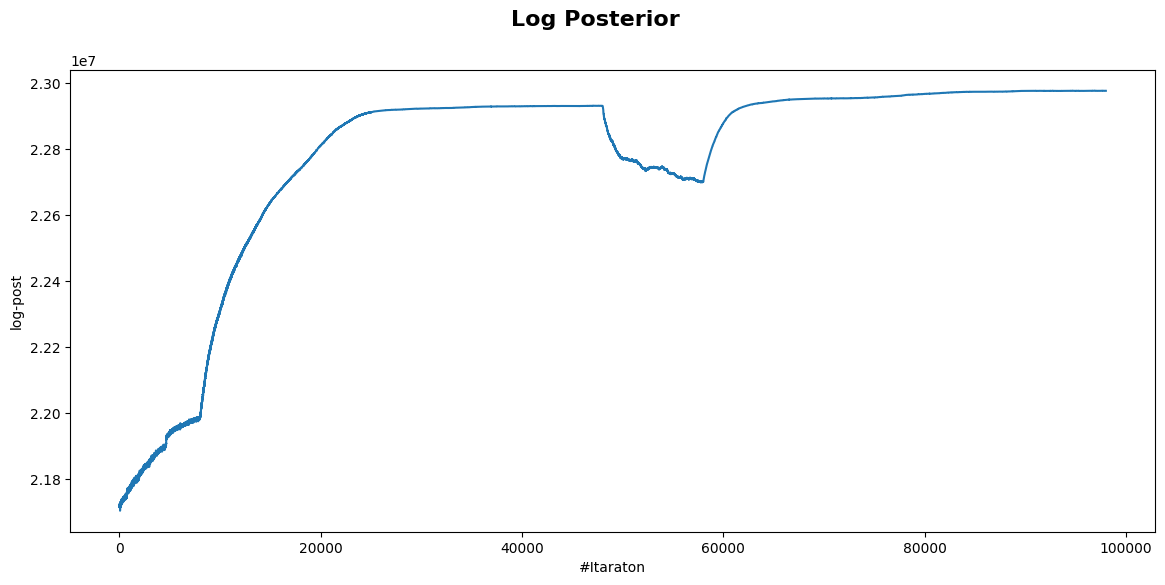

In [22]:
D = np.load('chains/chains1/Log_post_2.npy')
rbg1 = np.zeros(D.shape)+23031890.653924856
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
kk=2000
ax.plot(D[kk:])
# ax.plot(rbg1[kk:])
ax.set_xlabel("#Itaraton")
ax.set_ylabel("log-post")
fig.suptitle('Log Posterior', fontweight='bold', size=16)
print(f'last_step_posterior = {D[-1]}')
print(f'grand_truth_posterior = {rbg1[-1]}')
plt.show()

[1. 1. 0. 0. 0. 1.]


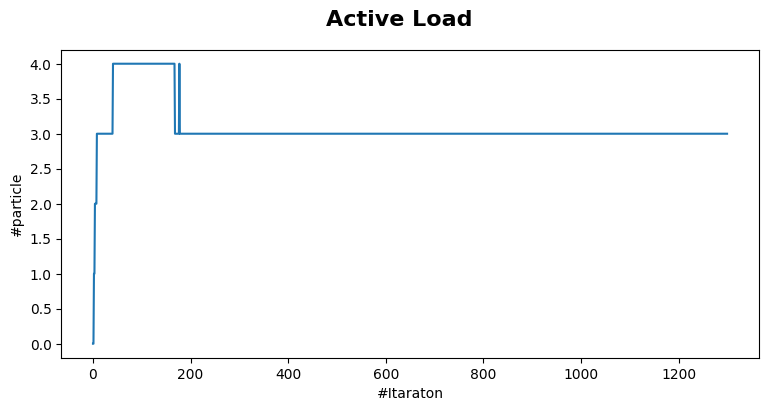

In [21]:
B = np.load('chains/chains1/loads2.npy')
print(B[-1])
B = np.sum(B,axis=1)
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.plot(B[:1300])
ax.set_xlabel("#Itaraton")
ax.set_ylabel("#particle")
fig.suptitle('Active Load', fontweight='bold', size=16)
# plt.savefig("./gr7/load.png")
plt.show()


In [10]:
XX = np.load('chains/chains1/chain2/X_1.npy')

XX.shape

(1000, 100, 6)

In [11]:
kk=1000
XX = np.load('chains/chains1/chain2/X_1.npy')
YY = np.load('chains/chains1/chain2/Y_1.npy')
ZZ = np.load('chains/chains1/chain2/Z_1.npy')
# print(f"xx = {XX.shape}")
XX = np.mean(XX[-kk:,:,:], axis=0)
YY = np.mean(YY[-kk:,:,:], axis=0)
ZZ = np.mean(ZZ[-kk:,:,:], axis=0)
rows = 6
cols = 1

fig = plt.figure(figsize=(21, 51))
# grid for pairs of subplots
grid = plt.GridSpec(rows, cols)

for i in range(rows * cols):
    # create fake subplot just to title set of subplots
    fake = fig.add_subplot(grid[i])
    # '\n' is important
    fake.set_title(f'Pariticle #{i+1}\n', fontweight='semibold', size=14)
    fake.set_axis_off()

    # create subgrid for two subplots without space between them
    # <https://matplotlib.org/2.0.2/users/gridspec.html>
    gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=grid[i])

    # real subplot #1
    ax = fig.add_subplot(gs[0])
    ax.plot(PSFstruct['X'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['X'][1], color = "darkgreen", label='Actuall_2')
    ax.plot(PSFstruct['X'][2], color = "darkblue", label='Actuall_3')
    ax.plot(XX[:,i], '-.', color = "coral", label='Learned')
    ax.set_title('X')
    ax.set_xlabel("frame")
    ax.set_ylabel("X (nm)")
    ax.legend()

    # real subplot #2
    ax = fig.add_subplot(gs[1], sharey=ax)
    ax.plot(PSFstruct['Y'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['Y'][1], color = "darkgreen", label='Actuall_2')
    ax.plot(PSFstruct['Y'][2], color = "darkblue", label='Actuall_3')
    ax.plot(YY[:,i], '-.', color = "coral", label='Learned')
    ax.set_title('Y')
    ax.set_xlabel("frame")
    ax.set_ylabel("Y (nm)")
    ax.legend()
    
    # real subplot #3
    ax = fig.add_subplot(gs[2], sharey=ax)
    ax.plot(PSFstruct['Z'][0], color = "black", label='Actuall_1')
    ax.plot(PSFstruct['Z'][1], color = "darkgreen", label='Actuall_2')
    ax.plot(PSFstruct['Z'][2], color = "darkblue", label='Actuall_3')
    ax.plot(ZZ[:,i], '-.', color = "coral", label='Learned')
    ax.set_title('Z')
    ax.set_xlabel("frame")
    ax.set_ylabel("Z (nm)")
    ax.legend()

fig.patch.set_facecolor('white')
fig.suptitle('Trajectories', fontweight='bold', size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plt.savefig("/content/drive/My Drive/SML_result/traj3.png")
plt.show()

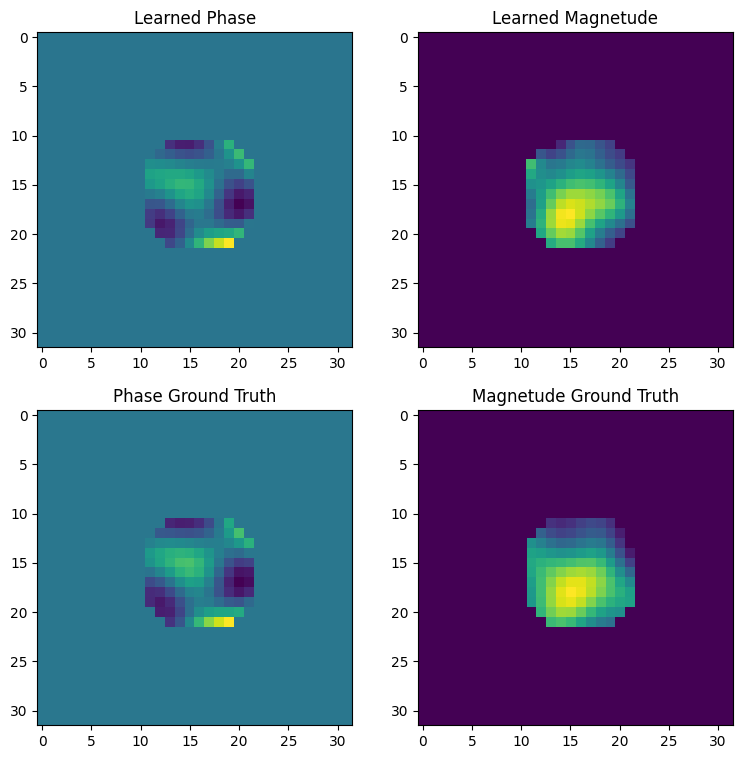

In [19]:
Phase = np.load('chains/chains1/Phase_2.npy')
tPhase = PSFstruct['Pupil_Phase']
Z0 = PSFstruct['ZImages'][:,:,0]
Zx = PSFstruct['ZImages'][:,:,1]
Zy = PSFstruct['ZImages'][:,:,2]
Zz = PSFstruct['ZImages'][:,:,3]
KPixelSize = 1/(PSFstruct['PixelSize']*PSFstruct['NPix'])
PupilRadius = PSFstruct['Na']/(PSFstruct['Lambda']*KPixelSize)
ADisk = pi*PupilRadius**2
Mask = PSFstruct['Mask']
tmpPhase = np.mean(Phase,axis=0)
for ii in range(30):
    XShift = np.sum(tmpPhase*Zx*Mask)/ADisk
    YShift = np.sum(tmpPhase*Zy*Mask)/ADisk
    ZShift = np.sum(tmpPhase*Zz*Mask)/ADisk
    Offset = np.sum(tmpPhase*Z0*Mask)/ADisk
    tmpPhase = (tmpPhase - XShift*Zx - YShift*Zy - ZShift*Zz - Offset*Z0)*Mask


tMag=(PSFstruct['Pupil_Mag'])
tMag[Mask==0] = 100
tMag[Mask==0] = np.min(tMag)
Mag = np.load('chains/chains1/Mag_2.npy')
tmpMag = np.mean(Mag,axis=0)
tmpMag[Mask==0] = 100
tmpMag[Mask==0] = np.min(tmpMag)

fig, ax = plt.subplots(2, 2, figsize=(9, 9))

ax[0,0].imshow(tmpPhase)
ax[0,0].set_title('Learned Phase')
ax[0,1].imshow(tmpMag)
ax[0,1].set_title('Learned Magnetude')
ax[1,1].imshow(tMag)
ax[1,1].set_title('Magnetude Ground Truth')
ax[1,0].imshow(tPhase)
ax[1,0].set_title('Phase Ground Truth' )
# plt.savefig("./gr6/phase_mag6.png")
plt.show()

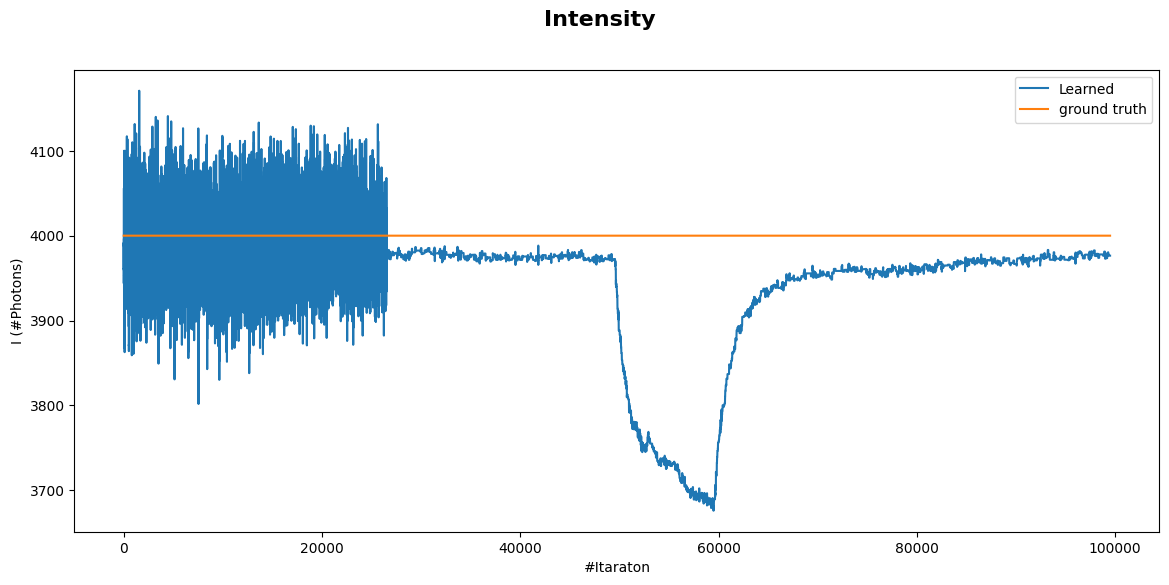

In [17]:
I = np.load('chains/chains1/I_2.npy')
rbg1 = np.zeros(I.shape)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
kk=500
ax.plot(I[kk:], label='Learned')
ax.plot(rbg1[kk:]+4000, label='ground truth')
ax.set_xlabel("#Itaraton")
ax.set_ylabel("I (#Photons)")
ax.legend()
fig.suptitle('Intensity', fontweight='bold', size=16)
# plt.savefig("./gr7/I.png")
plt.show()

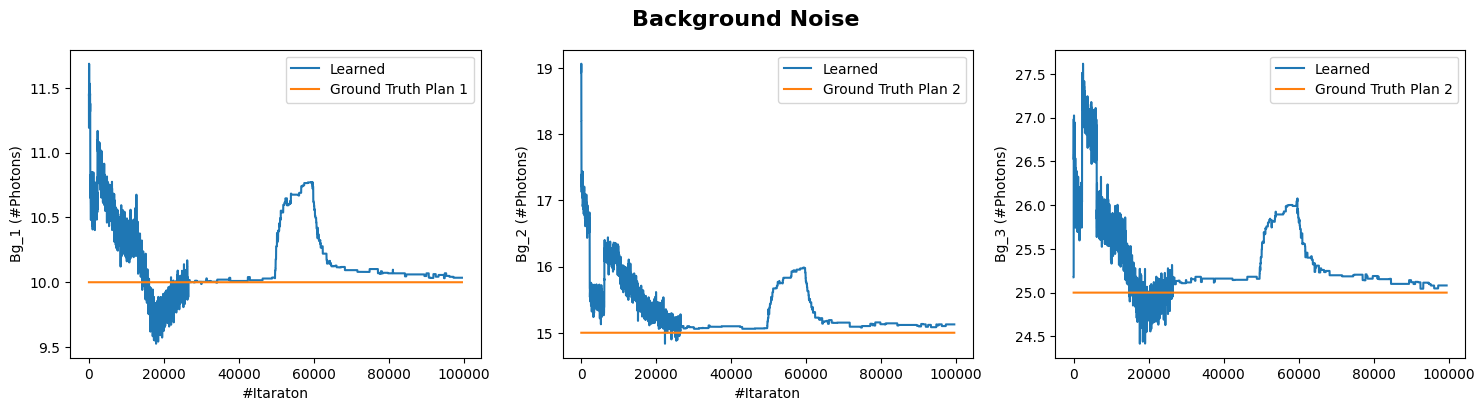

In [16]:
Bg = np.load('chains/chains1/Bg_2.npy')
rbg1 = np.zeros(Bg.shape[0])+10
rbg2 = np.zeros(Bg.shape[0])+15
rbg3 = np.zeros(Bg.shape[0])+25
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
kk=500
ax[0].plot(Bg[kk:,0], label='Learned')
ax[1].plot(Bg[kk:,1], label='Learned')
ax[2].plot(Bg[kk:,2], label='Learned')
ax[0].plot(rbg1[kk:], label='Ground Truth Plan 1')
ax[1].plot(rbg2[kk:], label='Ground Truth Plan 2')
ax[2].plot(rbg3[kk:], label='Ground Truth Plan 2')
ax[0].set_ylabel("Bg_1 (#Photons)")
ax[0].set_xlabel("#Itaraton")
ax[1].set_xlabel("#Itaraton")
ax[1].set_ylabel("Bg_2 (#Photons)")
ax[1].set_xlabel("#Itaraton")
ax[2].set_ylabel("Bg_3 (#Photons)")
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.suptitle('Background Noise', fontweight='bold', size=16)
# plt.savefig("./gr7/BG.png")
plt.show()

In [4]:
D = np.load('chains/chains1/D_5.npy')
rbg1 = np.zeros(D.shape)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
kk=200
ax.plot(D[kk:])
ax.plot(rbg1[kk:]+40,)
ax.set_xlabel("#Itaraton")
ax.set_ylabel("D (nm^2/ms)")
ax.legend()
fig.suptitle('Diffusion coeficent', fontweight='bold', size=16)
# plt.savefig("./gr7/D.png")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [16]:
def Invgampdf(x, a, b):
    y = b**a/gamma(a)*x**(-a-1)*exp(-b/x)
    return y

In [122]:
AlphaPrior = 9
BetaPrior = 99

D = np.arange(1,200)

In [123]:
aa = []
for _ in range(100000):
    aa.append(1/np.random.gamma(shape=AlphaPrior, scale =BetaPrior))
a =np.array(aa)
plt.hist(a, bins=100)
plt.show()

In [119]:
a= 20
b = 590
(b**2)/((a-1)**2 * (a-2))

53.57032933210218

In [120]:
b/(a-1)

31.05263157894737